# Import data

In [ ]:
import tensorflow as tf
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
import pandas as pd
import numpy as np

ins_df = pd.read_csv('data/instagram_data.csv')
ins_df = ins_df[ins_df['Contents'].notna()] # We might want to do something different here - SN
ins_df

,imagename,postid,dataset,dataset.1,postdate,Contents,url,Q1_pertain_to_covid,Q2_cetegory,Q2A_Type of Human,...,Q8_threat_covid,Q9_susceptibility_covid,Q9A_Asian responsible for the covid,Q10_solution_present,Q11_recommended_solution,misinformation,Q12 Presence of conspiracy theory,Q12-Others,Q13. Image of plague doctor costume,Note
0,B-A5FIIIEKJ,5592,middle,2,3/21/20,#covid #covid2020 #covidvirus #virus #coronava...,https://www.instagram.com/p/B-A5FIIIEKJ/,1,1,1,...,1,1,2,1,1,0,2,99,2.0,Stay home
1,B-A74YQn_4a,5593,middle,2,3/21/20,Well this is the final mural of my trip in Aus...,https://www.instagram.com/p/B-A74YQn_4a/,1,1,1,...,1,1,2,2,99,0,2,99,2.0,NaN
2,B-AajnDp6GQ,5575,middle,2,3/21/20,Chegamos !!! Vão seguindo o movimento... Tem m...,https://www.instagram.com/p/B-AajnDp6GQ/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
3,B-AarR4pUQA,5576,middle,2,3/21/20,😻😻😻😻😻,https://www.instagram.com/p/B-AarR4pUQA/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
4,B-AE1y3HD-Z,5550,middle,2,3/21/20,EN MI DOMICILIO 🏡\r\r\r\r\n#quedateencasa\r\r\...,https://www.instagram.com/p/B-AE1y3HD-Z/,1,1,1,...,1,1,2,1,1,0,2,99,2.0,mask; Stay home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9643,CEZyheBgtMd,8402,second,3,8/27/20,#water #foryou #followforfollowback #photograp...,https://www.instagram.com/p/CEZyheBgtMd/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9644,CEZYoyRluKG,8352,second,3,8/27/20,#like4likes #20likes #tagforlikes #instalikes ...,https://www.instagram.com/p/CEZYoyRluKG/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9645,CEZz-solaUF,8403,second,3,8/27/20,🙈🥰😍👉🏽 @love_serie_karma #daancorona #daancoron...,https://www.instagram.com/p/CEZz-solaUF/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9646,CEZZ4P4j3rh,8354,second,3,8/27/20,💥🚨 𝗙𝗔𝗟𝗟 𝗜𝗦 𝗖𝗢𝗠𝗜𝗡𝗚 🚨💥⁣\r\r\r\r\r\n⁣\r\r\r\r\r\n...,https://www.instagram.com/p/CEZZ4P4j3rh/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN


In [2]:
from sklearn.utils import shuffle

anger_df = pd.read_csv('data/twitter/anger.tsv', sep='\t').drop(columns=['index', 'intensity'])
fear_df = pd.read_csv('data/twitter/fear.tsv', sep='\t').drop(columns=['index', 'intensity'])
joy_df = pd.read_csv('data/twitter/joy.tsv', sep='\t').drop(columns=['index', 'intensity'])
sadness_df = pd.read_csv('data/twitter/sadness.tsv', sep='\t').drop(columns=['index', 'intensity'])

emotion_df = pd.concat([anger_df, fear_df, joy_df, sadness_df])
emotion_df = shuffle(emotion_df)

emotion_df

,tweet,category
677,Sometimes he likes to ride arround on people's...,joy
402,November #canola lost $5.50 to $464.20 per tonne.,sadness
432,Anyone know how the #Mariners did today? The m...,joy
443,"When something makes you excited, terrified, t...",joy
15,Going home is depressing,sadness
...,...,...
314,It's so gloomy outside. I wish it was as cold ...,sadness
514,#Arts create richness &amp; liveliness in our ...,joy
590,@JBCrewdotcom how his own fans insult him,anger
777,ðŸ˜³The intensity that @sydneyswans play at is...,anger


# Feature Engineering

In [ ]:
!pip install --upgrade transformers datasets emoji deep-translator

In [3]:
import torch
from transformers import AutoTokenizer
from deep_translator import GoogleTranslator
import emoji

translator = GoogleTranslator(source='auto', target='en')

# Note: How we preprocess may depend on model we use to transfer. 
# This comes from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
def preprocess(text):
    new_text = []
    for t in text.split(" ")[:300]:
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace('\r', '')
        t = t.replace("\n", " ") # Remove newlines
        
        # Remove hashtags but keep words -- ended up leaving them as it seemed to perform better - SN
        t = ' #'.join(t.split("#")) if '#' in t else t
            
        # change emojis to be explanation of emoji
        if emoji.get_emoji_regexp().search(t) != None:
            t = ' '.join(emoji.demojize(i) for i in emoji.get_emoji_regexp().split(t))
            t = t.replace("_"," ")
            t = t.replace("-"," ")
            t = t.replace(":"," ")
    #         t = emoji.get_emoji_regexp().sub("", t)
    
        t = " ".join(t.split()) # Remove excess whitespace
        new_text.append(t)
    
    cleaned_text = " ".join(new_text)
    try:
        cleaned_text = translator.translate(cleaned_text) # Translate non english to english
    except Exception as e:
        print(e)
    
    if cleaned_text is None or len(cleaned_text.split()) == 0: return text # return original text if our cleaning made empty string
    return cleaned_text

# Load data into numpy arrays
X = np.array(emotion_df['tweet'])
Y = np.array(emotion_df['category'])
Y_ints = np.array(pd.factorize(emotion_df['category'])[0])
X_ins = np.array(ins_df['Contents'])
east_asian = np.array(ins_df['Q5A.  If yes to Q5, what type of Asian'] == 1, dtype=int)

# Preprocess text
for i in range(len(X)):     X[i] = preprocess(X[i])
for i in range(len(X_ins)): X_ins[i] = preprocess(X_ins[i])

# Split into train/val/test sets
TRAIN_PCT, VAL_PCT, TEST_PCT  = 0.6, 0.2, 0.2
train_idx = int(TRAIN_PCT * len(X))
val_idx = train_idx + int(VAL_PCT * len(X))

1 --> text must be a valid text with maximum 5000 character, otherwise it cannot be translated
 --> text must be a valid text with maximum 5000 character, otherwise it cannot be translated
 --> text must be a valid text with maximum 5000 character, otherwise it cannot be translated


In [4]:
for i in range(30): 
    print(np.array(ins_df['Contents'])[i])
    print('---')
    print(X_ins[i])
    print()
    print()
# print(i)

#covid #covid2020 #covidvirus #virus #coronavairus #coronavirus #coronavírus #coronavirüs #blackandwhite #blackandwhiteportrait #blackandwhitephoto #blackandwhite_photos #lockdown #lockdown2020 #lockdownlife #lockdownitaly #italylockdown #lockdowndiaries #lockdownactivities #stayathome #staysafe #stayhome #iorestoacasa #myhome #covid19 #covıd19 #covi̇d_19 #coviditalia #🖤 #🖤🖤🖤
---
covid covid2020 covidvirus virus coronavairus coronavirus coronavírus coronavirüs blackandwhite blackandwhiteportrait blackandwhitephoto blackandwhite_photos lockdown lockdown2020 lockdownlife lockdownitaly italylockdown lockdowndiaries lockdownactivities stayathome staysafe stayhome iorestoacasa myhome covid19 covıd19 covi̇d_19 coviditalia black heart black heart black heart black heart



#graff#graffiti#mural#muralart#muralgraffiti#streetart#artecallejero#portrait#retraro#painting#pintura#realismo#realism#hiperrealismo#hyperrealism#portrait#retrato#onlyspraypaint#onlyspray#noproyector#sinproyector#cobreart#

In [4]:
X_train, Y_train = X[:train_idx], Y_ints[:train_idx]
X_val, Y_val = X[train_idx:val_idx], Y_ints[train_idx:val_idx]
X_test, Y_test = X[val_idx:], Y_ints[val_idx:]


# TOKENIZER_MODEL = "cardiffnlp/twitter-roberta-base-sentiment" 
# TOKENIZER_MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
TOKENIZER_MODEL = "roberta-base"
# TOKENIZER_MODEL = 'bert-base-uncased'
# TOKENIZER_MODEL = 'siebert/sentiment-roberta-large-english'

# TOKENIZER_MODEL = 'bhadresh-savani/albert-base-v2-emotion'
# TOKENIZER_MODEL = 'bhadresh-savani/roberta-base-emotion'
# TOKENIZER_MODEL = 'bhadresh-savani/bert-base-uncased-emotion'
# TOKENIZER_MODEL = 'bhadresh-savani/distilbert-base-uncased-emotion'

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)

# Tokenize the data
# if TOKENIZER_MODEL == 'gpt2':
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})
X_ins_enc = tokenizer(list(X_ins), return_tensors='pt', padding=True, truncation=True)
X_train_enc = tokenizer(list(X_train), return_tensors='pt', padding=True, truncation=True, max_length=X_ins_enc['input_ids'].shape[1])
X_val_enc = tokenizer(list(X_val), return_tensors='pt', padding=True, truncation=True, max_length=X_ins_enc['input_ids'].shape[1])
X_test_enc = tokenizer(list(X_test), return_tensors='pt', padding=True, truncation=True, max_length=X_ins_enc['input_ids'].shape[1])

# Model Definition

In [5]:
# TODO: define our machine learning model, from our discussion it we can try deep learning models

import os
from torch.utils.data import (
    Dataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)

import math 
from transformers import  (
    BertPreTrainedModel, 
    RobertaConfig, 
    RobertaTokenizerFast,
    AutoModelForSequenceClassification
)

from transformers.optimization import (
    AdamW, 
    get_linear_schedule_with_warmup
)

from scipy.special import softmax
from torch.nn import CrossEntropyLoss

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
    roc_curve,
    auc,
    average_precision_score,
    accuracy_score
)

from transformers.models.roberta.modeling_roberta import (
    RobertaClassificationHead,
    RobertaConfig,
    RobertaModel,
)

from transformers import AutoModel
from torch import nn

num_labels = 4

In [11]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('Number of GPUs: ',torch.cuda.device_count())
else:
    print('No GPU, using CPU.')
    device = torch.device("cpu")

Number of GPUs:  1


In [12]:
max_seq_length = 128 
train_batch_size = 8
test_batch_size = 8
warmup_ratio = 0.06
weight_decay=0.0
gradient_accumulation_steps = 1
num_train_epochs = 5
learning_rate = 1e-05
adam_epsilon = 1e-08

hidden_units = 512

In [10]:
MODEL, pretrained_output_size = "roberta-base", 768

class RobertaClassification(BertPreTrainedModel):
    
    def __init__(self, config, MODEL=None, num_labels=None, pretrained_output_size=None, hidden_units=None):
        super(RobertaClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)
        self.classifier = RobertaClassificationHead(config)
        
        
    def forward(self, input_ids, attention_mask, labels):
        outputs = self.roberta(input_ids,attention_mask=attention_mask)
        sequence_output = outputs[0]
        
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

config_class = RobertaConfig
model_class = RobertaClassification

config = config_class.from_pretrained(MODEL, num_labels=num_labels)
model = model_class.from_pretrained(MODEL, config=config)
print('Model=\n',model,'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this 

Model=
 RobertaClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [13]:
# If you want to use a different model than roberta-base above
# Uncomment MODEL you want
# MODEL, pretrained_output_size = "roberta-base", 768
# MODEL, pretrained_output_size = 'bhadresh-savani/albert-base-v2-emotion', 6
MODEL, pretrained_output_size = 'bhadresh-savani/roberta-base-emotion', 6
# MODEL, pretrained_output_size = 'bhadresh-savani/bert-base-uncased-emotion', 6
# MODEL, pretrained_output_size = "bhadresh-savani/distilbert-base-uncased-emotion", 6
# MODEL, pretrained_output_size = "cardiffnlp/twitter-roberta-base-sentiment", 768 
# MODEL, pretrained_output_size = "bert-base-uncased", 768
# MODEL, pretrained_output_size = "siebert/sentiment-roberta-large-english", 1024
# MODEL, pretrained_output_size = "digitalepidemiologylab/covid-twitter-bert-v2", 1024

assert MODEL == TOKENIZER_MODEL

class Model(nn.Module):
    
    def __init__(self, config, MODEL, num_labels, pretrained_output_size, hidden_units):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.pretrained_model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=6)

        self.linear1 = nn.Linear(pretrained_output_size, self.num_labels)

    def forward(self, input_ids, attention_mask, labels):
        output = self.pretrained_model(input_ids, attention_mask=attention_mask)

        out = self.linear1(output.logits)
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(out.view(-1, self.num_labels), labels.view(-1))
        
        return loss, out

model = Model(None, MODEL, num_labels, pretrained_output_size, hidden_units)
print('Model=\n',model,'\n')

Model=
 Model(
  (pretrained_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense

In [14]:
class MyClassificationDataset(Dataset):
    
    def __init__(self, data,y):
        text = data
        labels=y
        self.examples = text
#         targets = tr.transform(labels)
        self.labels = torch.as_tensor(labels, dtype=torch.long)
        

    def __len__(self):
        return len(self.examples["input_ids"])

    def __getitem__(self, index):
        return {key: self.examples[key][index] for key in self.examples}, self.labels[index]


train_dataset = MyClassificationDataset(X_train_enc,Y_train)
val_dataset = MyClassificationDataset(X_val_enc, Y_val)
test_dataset = MyClassificationDataset(X_test_enc, Y_test)
ins_dataset = MyClassificationDataset(X_ins_enc, [0.] * len(X_ins))

<ipython-input-14-011184b67429>:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.labels = torch.as_tensor(labels, dtype=torch.long)


In [15]:
train_batch_size = 8
val_batch_size = 8
test_batch_size = 8

def get_inputs_dict(batch):
    inputs = {key: value.squeeze(1).to(device) for key, value in batch[0].items()}
    inputs["labels"] = batch[1].to(device)
    return inputs

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=train_batch_size)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=val_batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=test_batch_size)

ins_sampler = SequentialSampler(ins_dataset)
ins_dataloader = DataLoader(ins_dataset, sampler=ins_sampler, batch_size=test_batch_size)

#Extract a batch as sanity-check
# batch = get_inputs_dict(next(iter(train_dataloader)))
# input_ids = batch['input_ids'].to(device)
# attention_mask = batch['attention_mask'].to(device)
# labels = batch['labels'].to(device)
# print(batch)

In [16]:
def setup_opts(model):
    t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
    optimizer_grouped_parameters = []
    custom_parameter_names = set()
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters.extend(
        [
            {
                "params": [
                    p
                    for n, p in model.named_parameters()
                    if n not in custom_parameter_names and not any(nd in n for nd in no_decay)
                ],
                "weight_decay": weight_decay,
            },
            {
                "params": [
                    p
                    for n, p in model.named_parameters()
                    if n not in custom_parameter_names and any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
    )

    warmup_steps = math.ceil(t_total * warmup_ratio)
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
    return optimizer, scheduler

optimizer, scheduler = setup_opts(model)

# Training

In [17]:
# TODO: train our model using the loaded data
model.to(device)

model.zero_grad()

def log_metrics(y, y_preds):
    print(classification_report(y, y_preds, target_names=['Joy', 'Fear', 'Sadness', 'Anger']))
    

def train_epochs(num_train_epochs):
    avg_loss=[]
    avg_val_loss=[]
    for epoch in range(num_train_epochs):

        model.train()
        epoch_loss = []
    
        for batch in train_dataloader:
            batch = get_inputs_dict(batch)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            epoch_loss.append(loss.item())
        
        #evaluate model with test_df at the end of the epoch.
        eval_loss = 0.0
        nb_eval_steps = 0
        n_batches = len(val_dataloader)
        preds = np.empty((len(val_dataset), num_labels))
        out_label_ids = np.empty((len(val_dataset)))
        model.eval()
    
        for i,test_batch in enumerate(val_dataloader):
            with torch.no_grad():
                test_batch = get_inputs_dict(test_batch)
                input_ids = test_batch['input_ids'].to(device)
                attention_mask = test_batch['attention_mask'].to(device)
                labels = test_batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                tmp_eval_loss, logits = outputs[:2]
                eval_loss += tmp_eval_loss.item()
            
            nb_eval_steps += 1
            start_index = test_batch_size * i
            end_index = start_index + test_batch_size if i != (n_batches - 1) else len(test_dataset)
            preds[start_index:end_index] = logits.detach().cpu().numpy()
            out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()
        
        eval_loss = eval_loss / nb_eval_steps
        model_outputs = preds
        preds = np.argmax(preds, axis=1)
        #result, wrong = compute_metrics(preds, model_outputs, out_label_ids)
        epoch_loss=np.mean(epoch_loss)
        print('epoch',epoch,'Training avg loss',epoch_loss)
        print('epoch',epoch,'Testing  avg loss',eval_loss)
        print('---------------------------------------------------\n')
        avg_loss.append(epoch_loss)
        avg_val_loss.append(eval_loss)
        
    report=log_metrics(Y_val, preds)
    print(report)
    avg_loss=np.mean(avg_loss)
    avg_val_loss=np.mean(avg_val_loss)
    accuracy=accuracy_score(Y_val, preds)
    return avg_loss,avg_val_loss,report,accuracy
        

# Performance Evaluation

In [18]:
def test():   
    model.to(device)
    eval_loss = 0.0
    nb_eval_steps = 0
    n_batches = len(test_dataloader)
    preds = np.empty((len(test_dataset), num_labels))
    out_label_ids = np.empty((len(test_dataset)))
    model.eval()
    for i,test_batch in enumerate(test_dataloader):
        with torch.no_grad():
            test_batch = get_inputs_dict(test_batch)
            input_ids = test_batch['input_ids'].to(device)
            attention_mask = test_batch['attention_mask'].to(device)
            labels = test_batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.item()

        nb_eval_steps += 1
        start_index = test_batch_size * i
        end_index = start_index + test_batch_size if i != (n_batches - 1) else len(test_dataset)
        preds[start_index:end_index] = logits.detach().cpu().numpy()
        out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()

    eval_loss = eval_loss / nb_eval_steps
    model_outputs = preds
    preds = np.argmax(preds, axis=1)
    print("classification report for test set")
    print(log_metrics(Y_test, preds))
    accuracy=accuracy_score(Y_test, preds)
    return eval_loss,accuracy

In [19]:
train_loss=[]
val_loss=[]
val_acc=[]
test_loss=[]
test_acc=[]
for epoch in range(2,12,2):
    print("train with epochs=",epoch)
    model = model_class.from_pretrained(MODEL, config=config)
#     model = Model(None, MODEL, num_labels, pretrained_output_size, hidden_units)
    model.to(device)
    optimizer, scheduler = setup_opts(model)
    
    avg_loss,avg_val_loss,report,accuracy=train_epochs(epoch)
    
    train_loss.append(avg_loss)
    val_loss.append(avg_val_loss)
    val_acc.append(accuracy)
    testloss,testacc=test()
    test_loss.append(testloss)
    test_acc.append(testacc)

train with epochs= 2
epoch 0 Training avg loss 1.064202389483962
epoch 0 Testing  avg loss 0.7075779739317003
---------------------------------------------------

epoch 1 Training avg loss 0.5976892662169309
epoch 1 Testing  avg loss 0.5792037864307781
---------------------------------------------------

              precision    recall  f1-score   support

         Joy       0.83      0.92      0.87       145
        Fear       0.77      0.75      0.76       149
     Sadness       0.90      0.68      0.77       182
       Anger       0.75      0.85      0.79       246

    accuracy                           0.80       722
   macro avg       0.81      0.80      0.80       722
weighted avg       0.81      0.80      0.80       722

None
classification report for test set
              precision    recall  f1-score   support

         Joy       0.83      0.87      0.85       185
        Fear       0.87      0.75      0.80       157
     Sadness       0.87      0.75      0.81       160
  

classification report for test set
              precision    recall  f1-score   support

         Joy       0.91      0.88      0.89       185
        Fear       0.86      0.82      0.84       157
     Sadness       0.76      0.84      0.80       160
       Anger       0.83      0.81      0.82       222

    accuracy                           0.84       724
   macro avg       0.84      0.84      0.84       724
weighted avg       0.84      0.84      0.84       724

None


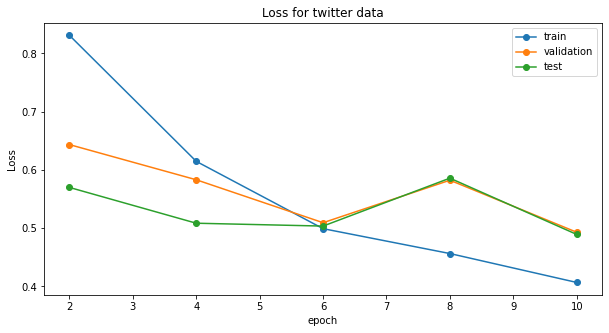

In [21]:
import matplotlib.pyplot as plt

x=[2,4,6,8,10]
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Loss for twitter data")
plt.plot(x,train_loss,marker='o',label='train')
plt.plot(x,val_loss,marker='o',label='validation')
plt.plot(x,test_loss,marker='o',label='test')
plt.legend()

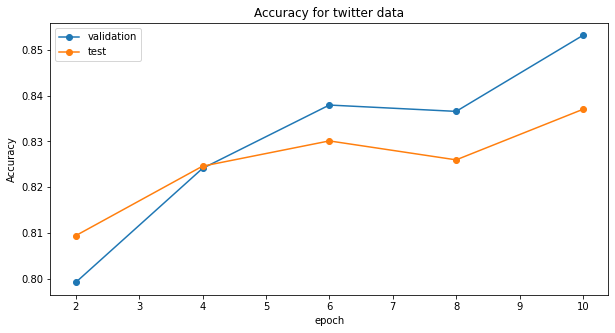

In [22]:
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy for twitter data")
plt.plot(x,val_acc,marker='o',label='validation')
plt.plot(x,test_acc,marker='o',label='test')
plt.legend()

# Prediction

In [23]:
# TODO: predict the submission data 
nb_eval_steps = 0
n_batches = len(ins_dataloader)
preds = np.empty((len(ins_dataset), num_labels))
model.eval()
    
for i,test_batch in enumerate(ins_dataloader):
    with torch.no_grad():
        test_batch = get_inputs_dict(test_batch)
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, logits = outputs[:2]

    nb_eval_steps += 1
    start_index = test_batch_size * i
    end_index = start_index + test_batch_size if i != (n_batches - 1) else len(ins_dataset)
    preds[start_index:end_index] = logits.detach().cpu().numpy()

model_outputs = preds
preds = np.argmax(preds, axis=1)
np.savetxt('instagram_predictions-with-hash.txt', preds) # We might want to do something different here - SN

In [8]:
from scipy.stats import pearsonr
# from scipy.stats import spearmanr
emotions = ['Joy', 'Fear', 'Sadness', 'Anger']

preds_one_hot = np.zeros((len(preds), preds.max()+1))
preds_one_hot[np.arange(len(preds)),preds] = 1

for i in range(num_labels):
    corr, _ = pearsonr(preds_one_hot[:,i], east_asian)
    print('Correlation with {}: {}'.format(emotions[i], corr))

In [24]:
for i in range(20):
    print('Prediction: {} \nProcessed:\n{}\nUnprocessed:\n{}\n\n'.format(emotions[preds[i]], X_ins[i],np.array(ins_df['Contents'])[i]))

Prediction: Anger 
Processed:
#covid #covid2020 #covidvirus #virus #coronavairus #coronavirus #coronavírus #coronavirüs #blackandwhite #blackandwhiteportrait #blackandwhitephoto #blackandwhite_photos #lockdown #lockdown2020 #lockdownlife #lockdownitaly #italylockdown #lockdowndiaries #lockdownactivities #stayathome #staysafe #stayhome #iorestoacasa #myhome #covid19 #covıd19 #covi̇d_19 #coviditalia # black heart # black heart black heart black heart
Unprocessed:
#covid #covid2020 #covidvirus #virus #coronavairus #coronavirus #coronavírus #coronavirüs #blackandwhite #blackandwhiteportrait #blackandwhitephoto #blackandwhite_photos #lockdown #lockdown2020 #lockdownlife #lockdownitaly #italylockdown #lockdowndiaries #lockdownactivities #stayathome #staysafe #stayhome #iorestoacasa #myhome #covid19 #covıd19 #covi̇d_19 #coviditalia #🖤 #🖤🖤🖤


Prediction: Fear 
Processed:
Well this is the final mural of my trip in Australia, a very weird trip, to be honest I couldn’t connect with my painting, a

# Naive Bayes

In [9]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

vectorizer = CountVectorizer() 
vectorizer.fit(X_train)
train_vec = vectorizer.transform(X_train) 
test_vec = vectorizer.transform(X_test)
nb = MultinomialNB() 
nb.fit(train_vec, Y_train)
naive_preds = nb.predict(test_vec)
print('Accuracy: {:.3}%'.format(metrics.accuracy_score(Y_test, naive_preds)*100))
print(classification_report(y_true=Y_test, y_pred=naive_preds))

ins_vec = vectorizer.transform(X_test)
naive_preds = nb.predict(ins_vec)
for i in range(20):
    print('Prediction: {} \nProcessed:\n{}\nUnprocessed:\n{}\n\n'.format(emotions[naive_preds[i]], X_ins[i],np.array(ins_df['Contents'])[i]))

Accuracy: 77.3%
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       185
           1       0.76      0.64      0.69       157
           2       0.78      0.79      0.79       160
           3       0.70      0.86      0.77       222

    accuracy                           0.77       724
   macro avg       0.78      0.76      0.77       724
weighted avg       0.78      0.77      0.77       724

Prediction: Fear 
Processed:
#covid #covid2020 #covidvirus #virus #coronavairus #coronavirus #coronavírus #coronavirüs #blackandwhite #blackandwhiteportrait #blackandwhitephoto #blackandwhite_photos #lockdown #lockdown2020 #lockdownlife #lockdownitaly #italylockdown #lockdowndiaries #lockdownactivities #stayathome #staysafe #stayhome #iorestoacasa #myhome #covid19 #covıd19 #covi̇d_19 #coviditalia # black heart # black heart black heart black heart
Unprocessed:
#covid #covid2020 #covidvirus #virus #coronavairus #coronavirus #coronavírus #corona

In [10]:
np.savetxt('instagram_predictions-naive.txt', naive_preds)

# Prediction conversion

In [42]:
emotions = ['Joy', 'Fear', 'Sadness', 'Anger']

ins_df = pd.read_csv('data/instagram_data.csv')
ins_df = ins_df[ins_df['Contents'].notna()]

preds = np.loadtxt('instagram_predictions-with-hash.txt')
string_preds = []
for pred in preds:
    string_preds.append(emotions[int(pred)])

idxs = np.expand_dims(np.array(ins_df.index), -1)
string_preds = np.expand_dims(np.array(string_preds), -1)

final_preds = np.concatenate([idxs, string_preds], -1)
# print(final_preds.dtype)
np.savetxt('final_instagram_predictions.txt', final_preds, fmt='%s')

<U21
